In [1]:
import gym

import torch
import torch.nn as nn
from torch.distributions import Categorical
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
env = gym.make("CartPole-v0")

In [3]:
class Net(nn.Module):
    def __init__(self, observation_space, action_space):
        super(Net, self).__init__()
        self.state_space = observation_space
        self.action_space = action_space
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_space, bias=False)
        
        self.model = torch.nn.Sequential(
                self.l1,
                nn.ReLU(),
                self.l2
            )
        
        self.reset_history()
        
    def reset_history(self):
        self.log_probs = []
        self.rewards = []
    
    def forward(self, x):    
            return self.model(x)
    
    def act(self, state):
        x = torch.from_numpy(state.astype(np.float32))
        logits = self.forward(x)
        pd = Categorical(logits=logits)
        action = pd.sample()
        log_prob = pd.log_prob(action)
        self.log_probs.append(log_prob)
        
        return action.item()
        
    
net = Net(env.observation_space.shape[0], env.action_space.n)
optimizer = torch.optim.Adam(net.parameters())

In [4]:
def train(net, optim, mean):
    T = len(net.rewards)
    rewards = []
    for t in range(T):
        reward_i = sum([r * (GAMMA ** i) for i, r in enumerate(net.rewards[t:])])
        rewards.append(reward_i)
    
    rewards = torch.Tensor(rewards - mean)
    log_probs = torch.stack(net.log_probs)
    
    loss = - rewards * log_probs
    loss = torch.sum(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [5]:
MAX_EPISODE = 500
GAMMA = 1
reward_hist = []
loss_hist = []
mean_hist = [0]

for i in range(MAX_EPISODE):
    done = False
    state = env.reset()
    net.reset_history()
    
    baseline = 0
    while not done:
        action = net.act(state)
        state, reward, done, _ = env.step(action)
        net.rewards.append(reward)
    
    R = sum(net.rewards)
    reward_hist.append(R)
    baseline = np.mean(reward_hist[-20:])
    mean_hist.append(baseline)
    print(f'Episode: {i} \t\t Reward: {R} \t\t Mean Reward: {baseline}' )
    
    loss = train(net, optimizer, baseline)
    loss_hist.append(loss)

Episode: 0 		 Reward: 16.0 		 Mean Reward: 16.0
Episode: 1 		 Reward: 25.0 		 Mean Reward: 20.5
Episode: 2 		 Reward: 52.0 		 Mean Reward: 31.0
Episode: 3 		 Reward: 22.0 		 Mean Reward: 28.75
Episode: 4 		 Reward: 13.0 		 Mean Reward: 25.6
Episode: 5 		 Reward: 20.0 		 Mean Reward: 24.666666666666668
Episode: 6 		 Reward: 9.0 		 Mean Reward: 22.428571428571427
Episode: 7 		 Reward: 19.0 		 Mean Reward: 22.0
Episode: 8 		 Reward: 23.0 		 Mean Reward: 22.11111111111111
Episode: 9 		 Reward: 26.0 		 Mean Reward: 22.5
Episode: 10 		 Reward: 17.0 		 Mean Reward: 22.0
Episode: 11 		 Reward: 23.0 		 Mean Reward: 22.083333333333332
Episode: 12 		 Reward: 13.0 		 Mean Reward: 21.384615384615383
Episode: 13 		 Reward: 22.0 		 Mean Reward: 21.428571428571427
Episode: 14 		 Reward: 19.0 		 Mean Reward: 21.266666666666666
Episode: 15 		 Reward: 22.0 		 Mean Reward: 21.3125
Episode: 16 		 Reward: 28.0 		 Mean Reward: 21.705882352941178
Episode: 17 		 Reward: 12.0 		 Mean Reward: 21.166666666666668


In [6]:
net

Net(
  (l1): Linear(in_features=4, out_features=128, bias=False)
  (l2): Linear(in_features=128, out_features=2, bias=False)
  (model): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=False)
  )
)

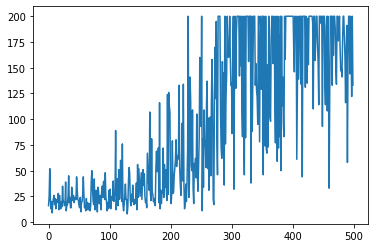

In [7]:
plt.plot(reward_hist)

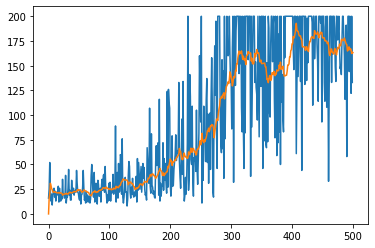

In [8]:
plt.plot(reward_hist)
plt.plot(mean_hist)